# IBM Datathon Walkthrough Notebook

##### Inculded in this notebook, is the use of llama to label an unlabelled dataset, to allow for an XGBoost model to classify. Creating a more time efficient pipeline not reliant on large computationally expensive LLMs. In this notebook we harnessed the power of IBM Z architecture to host Llama-13b, our embedding model (BAAI/bge-base-en-v1.5) and to create a XGBoost model to be used later in our Tweet Response API.

## Llama Unlabelled Data Pipeline

#### Importing open-soruce libraries

In [41]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.utils import shuffle
from tqdm import tqdm

#### Setting up Llama Pipeline

In [6]:
llama = pipeline("text-generation", model="meta-llama/Llama-2-13b-hf")

#### Data set-up

In [7]:
data = pd.read_csv('unlabelled_data.csv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [12]:
shuffled_data = shuffle(data)

In [13]:
textual_data = shuffled_data['text'].values

#### Function to decode LLM response

In [14]:
def decode_string(string_output):
    string_output = string_output[1:]
    outputs = string_output.split('.')
    if outputs[0] == "No" or outputs[0] == " No":
        return 0, None
    else:
        outputs = string_output.split(',')
        if outputs[0] == "Yes" or outputs[0] == " Yes":
            return 1, outputs[1][1: ]
        else:
            print(f'Error Processing Output {string_output}')
            return None, None

In [15]:
labelled_data = []

#### Using LLM to classify the twitter data into 1 and 0, 1 for charitable cause. It will also include a topic area for charitable cause if 1.

In [20]:
for input in tqdm(textual_data):
    prompt = f'''Does the text has a charitable cause?
                Input: People lost their families in Gaza after their homes were bombed by Israel missiles in painful scene.___
    #غزة_الآن#Gazagenocide#طوفان_الاقصى_#IsraeliWarCrimes#IsraeliWarCrimes#IsraelTerrorists#PalestineLivesMatter #Palestine
                Output: Yes, Palestine-Israel War.
                Input: Get your Greek on in London - with these recommendations for cuisine, culture and more! 🇬🇷
                Output: No.
                Input: 
                Output: No.
                Input: Good morning, I have committed to keep my friends informed of my updates concerning my battle with breast cancer. Regrettably, my doctor recently informed me that my treatment has been discontinued, as there are no further viable options available.
                Output: Yes, Breast Cancer.
                Input: I can't beleive what climate change is doing to the forests.
                Output: Yes, Climate Change / Deforestation. 
                Input: Just had a sit down with an old friend of mine for dinner. So nice to catch up with old friends. #reuniuons #oldschool friends
                Output: No.
                Input: David Bowie: Candid pictures of singer on tour go on display
                Output: No.
                Input: Boarding School Employee jailed for sexual assault.
                Output: Yes, Sexual Assualt.
                Input: A Ukrainian son cannot contain his joy when sees his father returning from the war.
                Output: Yes, Russian-Ukraine War.
                Input: {input}
                Output:'''      
    output = llama(prompt)
    answer, charity = decode_string(output)
    if (answer and charity) != None: 
        labelled_data.append([answer, charity, input])

100%|██████████| 7613/7613 [00:00<00:00, 3367208.30it/s]


#### Export and save new data

In [22]:
df = pd.DataFrame(labelled_data)
df.columns = ['Type', 'Charity', 'Text']

In [23]:
df.to_csv("New_Labelled_Data.csv", index=False)

## Creating XGBoost model from labelled LLM data

In [24]:
encoding_model = SentenceTransformer('BAAI/bge-base-en-v1.5')

In [27]:
data = pd.read_csv('New_Labelled_Data.csv')

In [43]:
data.head()

,Type,Charity,Text
0,1,Gun Violence.,Boy 11 charged with manslaughter in shooting d...
1,0,NaN,IM GONNA GET NAKED AND SMOKE MY CIGARETTE some...
2,0,NaN,It hurts for me to eat cause i burned my toung...
3,0,NaN,Crushed the gym then crushed a butterfinger fl...
4,1,California Wildfires.,ÛÏYou see the devastation &amp; itÛªs shocki...


In [28]:
X = data['Text'].values
y = data['Type'].values

In [30]:
X_en = encoding_model.encode(X)

In [36]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, y_Train, y_Test = train_test_split(X_en, y, test_size=0.3)

### Training XGBoost with our data

In [38]:
from xgboost import XGBClassifier
classifier = XGBClassifier(max_depth=10, n_estimators=400)
classifier.fit(X_Train, y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [39]:
y_pred = classifier.predict(X_Test)

### Confusion Matrix:

0.8861904761904762


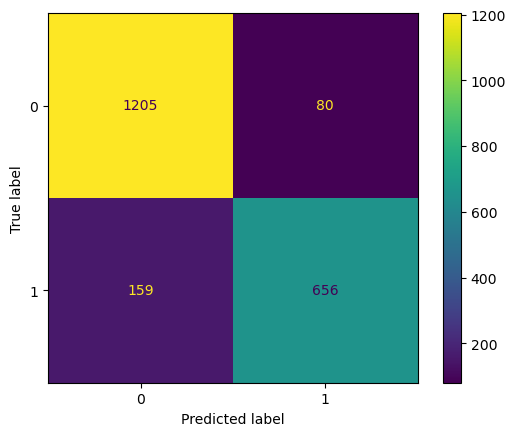

In [40]:
cm = confusion_matrix(y_Test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
print(accuracy_score(y_Test, y_pred))

### Save Model which is then run in our FLASK backend, ready for API requests

In [ ]:
classifier.save_model('XGB_Model.bst')

# APPENDIX A

### Additional code run in backend

In [ ]:
from sentence_transformers import SentenceTransformer, util
import xgboost as xgb
import pandas as pd
import time
import spacy
import requests
from bs4 import BeautifulSoup

nlp = spacy.load("en_core_web_sm")

encoding_model = SentenceTransformer('BAAI/bge-base-en-v1.5')
bst = xgb.Booster()
bst.load_model('XGB_Model2.bst')

chartiy_label_data = pd.read_parquet('Charity_Embeddings.parquet')
charities = chartiy_label_data['Charity'].values
charities_embeddings = chartiy_label_data['Embedding'].values

def search(query, num_results=10):
    base_url = "https://www.google.com/search"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    params = {
        "q": query + ' Charity to donate to',
        "count": num_results
    }

    response = requests.get(base_url, headers=headers, params=params)
    soup = BeautifulSoup(response.text, 'html.parser')

    urls = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if href and href.startswith("http"):
            urls.append(href)

    filtered_urls = [url for url in urls if "google" not in url]
    filtered_urls = [url for url in filtered_urls if "facebook" not in url]
    filtered_urls = [url for url in filtered_urls if "wikipedia" not in url]

    domain_names = []
    final_list = []

    for url in filtered_urls:
        split_url = url.split('/')
        if split_url[2] not in domain_names:
            domain_names.append(split_url[2])
            final_list.append(url)
    
    final_string = ''
    for strings in final_list[:3]:
        final_string += strings + ' '
    return final_string


def extract_locations(text):
    doc = nlp(text)
    locations = [entity.text for entity in doc.ents if entity.label_ == 'GPE']  # 'GPE' represents geopolitical entity
    return locations

def find_highest_sim_charity(tweet, charities):
    highest = [0, 0]
    for i, charity in enumerate(charities):
        dotScore = util.dot_score(charity, tweet)
        if dotScore > highest[1]:
            highest = [i, dotScore]
    return highest

def get_charity(tweet):
    encoded_tweet = encoding_model.encode(tweet)
    dtest = xgb.DMatrix([encoded_tweet])
    print(bst.predict(dtest))
    isCharity = 1 if bst.predict(dtest) > 0.5 else 0 
    if isCharity == 0:
        return 'No Charity'
    sim = find_highest_sim_charity(encoded_tweet, charities_embeddings)
    highest_charity = charities[sim[0]]


    locations = extract_locations(tweet)
    for location in locations:
        highest_charity += " " + location
    
    result = search(highest_charity)
    return result